In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
import copy

Evaluation function

In [2]:
# Evaluation function defined in Kaggle
def evaluation_function(validation, prediction):
    # Replace values with thresholds
    y_pred = np.clip(prediction, 1e-15, 1 - 1e-15)

    # One-hot encode y_true
    y_true_encoded = np.zeros_like(y_pred)
    for idx, class_idx in enumerate(validation):
        y_true_encoded[idx, class_idx] = 1

    return -1/len(prediction) * sum([sum([y_true_encoded[i][j] * np.log(y_pred[i][j]) for j, v in enumerate(y_pred[i])]) for i, w in enumerate(y_pred)])

# initialise scoring function for hyperparameter tuning
custom_scorer = make_scorer(evaluation_function, greater_is_better=False, needs_proba=True)

Preprocessesing

In [3]:
# Label categorical data with integers
def load_data(path):
    data = pd.read_csv(path)
    no_yes = {'N': 0, 'Y': 1}
    labeling = {'Sex': {'F': 1, 'M': 0},
                'Drug': {'Placebo': 0, 'D-penicillamine': 1},
                'Ascites': no_yes,
                'Hepatomegaly': no_yes,
                'Spiders': no_yes,
                'Edema': {'N': 0, 'Y': 1, 'S': 2},
                'Status': {'C': 0, 'D': 1, 'CL': 2}
                }
    for column, mapping in labeling.items():
        if column in data.columns:
            data[column] = data[column].replace(mapping)

    return data

# Non-tree based models require different preprocessing (normalized scales + one-hot-encoded categorical data)
class Preprocessor:

    # For rescaling you need to fit the training set without test-set to avoid data leakage
    def __init__(self, X_train):
        self.continuous_features = [0, 2, 8, 9, 10, 11, 12, 13, 14, 15, 16]
        self.scaler = StandardScaler()
        self.scaler.fit(X_train[:, self.continuous_features])
    
    # function for categorical data encoding of Edema
    def one_hot_encode(self, X):
        nominal_feature = 7
        zeros = np.zeros((len(X), 3))
        for row, val in enumerate(X[:, nominal_feature]):
            zeros[row][int(val)] = 1
        X_one_hot = np.concatenate((X, zeros), axis=1)
        X_one_hot = np.delete(X_one_hot, nominal_feature, 1)
        return X_one_hot

    def __call__(self, X):
        X = copy.deepcopy(X)
        # normalize data
        X[:, self.continuous_features] = self.scaler.transform(X[:, self.continuous_features])

        # one hot encode nominal features
        return self.one_hot_encode(X)

Load data

In [4]:
# Load data
train_data = load_data('./input_data/train.csv')
test_data = load_data('./input_data/test.csv')

X = train_data.drop(['Status', 'id'], axis=1).to_numpy()
Y = train_data['Status'].to_numpy()
X_val = np.array(test_data.drop('id', axis=1))

# Split data for hyperparameter search and model evaluation
testsize = 0.2
split_index = int((1 - testsize) * len(X))
X_train, X_test, Y_train, Y_test = X[:split_index], X[split_index:], Y[:split_index], Y[split_index:]

Support vector machine

In [5]:
svm = SVC(probability=True)

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

preprocess = Preprocessor(X_train)
grid_search = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, scoring=custom_scorer)
grid_search.fit(preprocess(X_train), Y_train)
prediction = grid_search.predict_proba(preprocess(X_test))

svm_params = grid_search.best_params_

print(f'Best parameters: {svm_params}')
print(f'Evaluation score: {evaluation_function(Y_test, prediction)}')

Best parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Evaluation score: 0.507894500610638


Random forest classifier - Hyperparameter grid search

In [6]:
model = RandomForestClassifier()
param_grid = {'max_depth': [15],
              'n_estimators': [600],
              'min_samples_split': [3],
              'min_samples_leaf': [2]
              }

# 5 fold cross validation
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, Y_train)

randomforest_params = grid_search.best_params_
print("Best parameters:", grid_search.best_params_)
prediction = grid_search.predict_proba(X_test)
print(f'Evaluation score: {evaluation_function(Y_test, prediction)}')

Best parameters: {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 600}
Evaluation score: 0.45484388659302855


Best parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}
Evaluation score: 0.45364399366663466

Try different init weights

In [7]:
models = [RandomForestClassifier(**randomforest_params, random_state=_) for _ in range(100)]
scores = []
for model in models:
    model.fit(X_train, Y_train)
    prediction = model.predict_proba(X_test)
    scores.append(evaluation_function(Y_test, prediction))
best_model_ind = np.argmin(scores)
print(scores[best_model_ind])
randomforest_params['random_state'] = best_model_ind    

# best_model_ind = 84   score = 0.4518

0.45149522397632935


Train model on whole dataset

In [8]:
#randomforest_params['random_state'] = 84            # from cell before

model = RandomForestClassifier(**randomforest_params)
model.fit(X, Y)

ids = test_data['id']
prediction = model.predict_proba(X_val)

submission = pd.DataFrame(data={'id': ids, 'Status_C': prediction[:, 0], 'Status_CL': prediction[:, 2], 'Status_D': prediction[:, 1]})
submission.to_csv('./output_data/randomforest_submission.csv', index=False)

Analysis

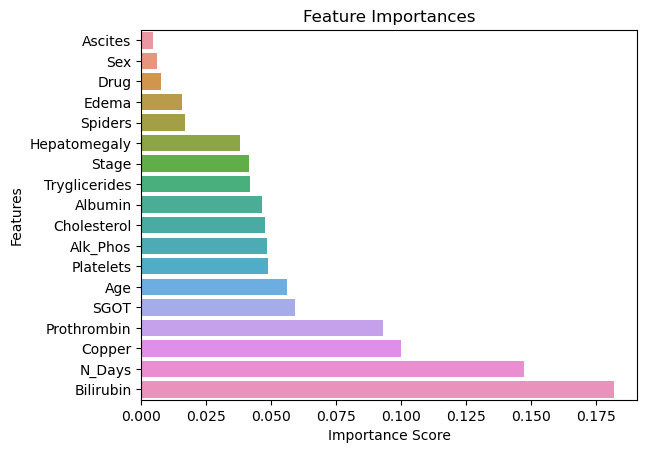

In [9]:
importances = model.feature_importances_
sorting = np.argsort(importances)

import matplotlib.pyplot as plt
import seaborn as sns

sns.barplot(x=importances[sorting], y=train_data.drop(['id', 'Status'], axis=1).keys()[sorting])
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

XGBoost Method

In [10]:
dtrain = xgb.XGBClassifier(objective='multi:softprob', num_class=3)

randomized_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 300, 500, 800, 1000],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 5],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1, 5, 10]
    }

random_search = RandomizedSearchCV(estimator=dtrain,
                                   param_distributions=randomized_param_grid,
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1,
                                   scoring=custom_scorer)
random_search.fit(X_train, Y_train)
prediction = random_search.predict_proba(X_test)
booster_params = random_search.best_params_
print(f'Best parameters: {booster_params}')
print(f'Evaluation score: {evaluation_function(Y_test, prediction)}')

Best parameters: {'subsample': 0.5, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.3}
Evaluation score: 0.42943106590479185


In [11]:
params = grid_search.best_params_
model = xgb.XGBClassifier(objective='multi:softprob', num_class=3,
                          **booster_params)
model.fit(X, Y)

prediction = model.predict_proba(X_val)
submission = pd.DataFrame(data={'id': ids, 'Status_C': prediction[:, 0], 'Status_CL': prediction[:, 2], 'Status_D': prediction[:, 1]})
submission.to_csv('./output_data/booster_submission.csv', index=False)

Stacked model - Tree, Booster, Regressor, SVM

Gridsearch for Regressor

In [12]:
# C - inverse regularization strength (stronger regularization with smaller vals)
param_grid = {'C': [0.1, 0.2, 0.4],
              'l1_ratio': [0.05, 0.1, 0.2]
              }

model = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', max_iter=2000)

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=custom_scorer)

# initialize preprocessing class for normalization and one hot encoding
preprocess = Preprocessor(X_train)
grid_search.fit(preprocess(X_train), Y_train)

test_prediction = grid_search.predict_proba(preprocess(X_test))
reg_params = grid_search.best_params_
print(f'Best params: {reg_params}')
print(f'Evaluation Score: {evaluation_function(Y_test, test_prediction)}')

Best params: {'C': 0.2, 'l1_ratio': 0.1}
Evaluation Score: 0.525243389713547


Best params: {'C': 0.2, 'class_weight': None, 'l1_ratio': 0.1}
Evaluation Score: 0.5250496040552972

Stack base models and train meta model

In [13]:
def init_models():
    randomforest = RandomForestClassifier(**randomforest_params)
    booster = xgb.XGBClassifier(objective='multi:softprob', 
                                num_class=3, 
                                **booster_params)
    regressor = LogisticRegression(penalty='elasticnet', solver='saga', multi_class='multinomial', max_iter=2000, **reg_params)
    svm = SVC(probability=True, **svm_params)
    return [randomforest, booster, regressor, svm]

# define indices of models to be used in stacked model
used_models = [0, 1, 2, 3]

In [14]:
def get_cross_val_predictions(model, X, y, cv=5):
    #Generates cross-validated predictions for a given model
    return cross_val_predict(model, X, y, cv=cv, method='predict_proba')

In [22]:
base_models = init_models()

# to avoid overfitting, the meta-features must be created with cross validated predictions whether than predictions on training set
X_meta_train = []
for i in used_models:
    if i >= 2:
        X_meta_train.append(get_cross_val_predictions(base_models[i], preprocess(X_train), Y_train))
    else:
        X_meta_train.append(get_cross_val_predictions(base_models[i], X_train, Y_train))

X_meta_train = np.column_stack(X_meta_train)

preprocess = Preprocessor(X_train)
# in cross-val predictions, base models are trained on part of the training data
# Here base models are trained on whole training data
for i in used_models:
    if i >= 2:
        base_models[i].fit(preprocess(X_train), Y_train)
    else:
        base_models[i].fit(X_train, Y_train)

Hyperparameter tuning for meta model

In [23]:
meta_params = {'hidden_layer_sizes': [(100)],
               'learning_rate_init': [0.001, 0.005],
               'alpha': [0, 0.00005, 0.0001, 0.001]
               }

mlp = MLPClassifier(max_iter=700)
grid_search = GridSearchCV(mlp, param_grid=meta_params, scoring=custom_scorer, cv=5)
grid_search.fit(X_meta_train, Y_train)
mlp_params = grid_search.best_params_

X_meta_test = []
for i in used_models:
    if i >= 2:
        X_meta_test.append(base_models[i].predict_proba(preprocess(X_test)))
    else:
        X_meta_test.append(base_models[i].predict_proba(X_test))

X_meta_test = np.column_stack(X_meta_test)
probabilities = grid_search.predict_proba(X_meta_test)

print(f'Best params: {mlp_params}')
print(f'Evaluation score: {evaluation_function(Y_test, probabilities)}')

Best params: {'alpha': 0, 'hidden_layer_sizes': 100, 'learning_rate_init': 0.001}
Evaluation score: 0.43226792444166545


Train MLPs on different init-weights

In [24]:
mlps = [MLPClassifier(max_iter=700, **mlp_params, random_state=_) for _ in range(100)]
scores = []
for classifier in mlps:
    classifier.fit(X_meta_train, Y_train)
    scores.append(evaluation_function(Y_test, classifier.predict_proba(X_meta_test)))
    
best_model_index = np.argmin(scores)
print(scores[best_model_index])

0.4276707752496222


Train Meta model on whole dataset

In [25]:
base_models = init_models()

preprocess = Preprocessor(X)

X_meta = []
X_meta_val = []
for i in used_models:
    if i >= 2:
        X_meta.append(get_cross_val_predictions(base_models[i], preprocess(X), Y))
        base_models[i].fit(preprocess(X), Y)
        X_meta_val.append(base_models[i].predict_proba(preprocess(X_val)))
    else:
        X_meta.append(get_cross_val_predictions(base_models[i], X, Y))
        base_models[i].fit(X, Y)
        X_meta_val.append(base_models[i].predict_proba(X_val))

X_meta = np.column_stack(X_meta)
X_meta_val = np.column_stack(X_meta_val)

mlp = MLPClassifier(max_iter=700, **mlp_params, random_state=best_model_index)
mlp.fit(X_meta, Y)

prediction = mlp.predict_proba(X_meta_val)
submission = pd.DataFrame(data={'id': ids, 'Status_C': prediction[:, 0], 'Status_CL': prediction[:, 2], 'Status_D': prediction[:, 1]})
submission.to_csv('./output_data/stacked_submission.csv', index=False)

Kaggle end score: 0.39668